In [111]:
import pandas as pd
import re
import pmdarima as pm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

### load and merge data

In [87]:
season_18_df = pd.read_csv('../data/2018_19_current_season_data.csv')

In [88]:
season_17_df = pd.read_excel('../data/FPL-201718-player-stats.xlsx')

In [89]:
def camelcase_columns(df):
    df.columns = [re.sub( r'(\n)?(\s)+', ' ', c).strip().lower().replace(' ','_').replace('£','p') for c in df.columns]
    return df

In [90]:
season_18_df = camelcase_columns(season_18_df)
season_17_df = camelcase_columns(season_17_df)

In [92]:
season_17_df.columns

Index(['gw_gameweek', 'opp_opposition', 'pts', 'mpminutes_played',
       'gsgoals_scored', 'aassists', 'csclean_sheets', 'gcgoals_conceded',
       'ogown_goals', 'pspenalties_saved', 'pmpenalties_missed',
       'ycyellow_cards', 'rcred_cards', 'ssaves', 'bbonus',
       'bpsbonus_points_system', 'iinfluence', 'ccreativity', 'tthreat',
       'iiict_index', 'nt_net_transfers', 'sb_selected_by', 'p_value', 'name',
       'team', 'position', 'total_score_rank'],
      dtype='object')

In [93]:
season_17_df['season'] = 2017
season_18_df['season'] = 2018

In [94]:
combined_df= season_17_df.append(season_18_df,sort=False)

In [157]:
combined_df['player_id'] = combined_df.name + '-' + combined_df.position

some duplicates :( - I'll ignore for now

In [167]:
combined_df.groupby(['player_id','season'])['pts'].count().sort_values(ascending=False).head()

player_id    season
Ward-DEF     2018      76
Simpson-DEF  2018      76
Bennett-DEF  2018      76
Ward-DEF     2017      76
Simpson-DEF  2017      64
Name: pts, dtype: int64

In [172]:
top_10 = combined_df.loc[combined_df.season==2017].groupby(['player_id'])['pts'].sum().sort_values(ascending=False).head(10); top_10

player_id
Salah-MID        303
Sterling-MID     229
Kane-FWD         217
De Bruyne-MID    209
Eriksen-MID      199
Mahrez-MID       195
Vardy-FWD        183
Firmino-FWD      181
Sané-MID         179
Son-MID          178
Name: pts, dtype: int64

In [173]:
top_10.index

Index(['Salah-MID', 'Sterling-MID', 'Kane-FWD', 'De Bruyne-MID', 'Eriksen-MID',
       'Mahrez-MID', 'Vardy-FWD', 'Firmino-FWD', 'Sané-MID', 'Son-MID'],
      dtype='object', name='player_id')

In [183]:
def fit_autoarima(data, player_id):
    train = data.loc[(data.player_id == player_id) &
                     (data.season == 2017),'pts']

    test = data.loc[(data.player_id == player_id) &
                     (data.season == 2018) &
                     (data.gw_gameweek < 11),'pts']
    # Fit a simple auto_arima model
    modl = pm.auto_arima(train, trace=1,seasonal=True,
                         stepwise=True, suppress_warnings=True, D=10, max_D=10,
                         error_action='ignore')

    # Create predictions for the future, evaluate on test
    preds, conf_int = modl.predict(n_periods=test.shape[0], return_conf_int=True)
    
    print(f"Test RMSE: {player_id} %.3f" % np.sqrt(mean_squared_error(test, preds)))

    plt.plot(np.arange(1,39), train, alpha=0.75)
    plt.plot(np.arange(39,49), preds, alpha=0.75)  # Forecasts
    plt.scatter(np.arange(39,49), test,
                alpha=0.4, marker='x')  # Test data
    plt.fill_between(np.arange(39,49),
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.1, color='b')
    plt.title(f"Points forecast - {player_id}")
    plt.xlabel("Gameweek")
    plt.show()
    return modl

Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=248.941, BIC=258.767, Fit time=0.149 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=244.126, BIC=247.401, Fit time=0.004 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=244.966, BIC=249.879, Fit time=0.018 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=244.887, BIC=249.800, Fit time=0.013 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=244.975, BIC=251.525, Fit time=0.089 seconds
Total fit time: 0.276 seconds
Test RMSE: Salah-MID 4.269


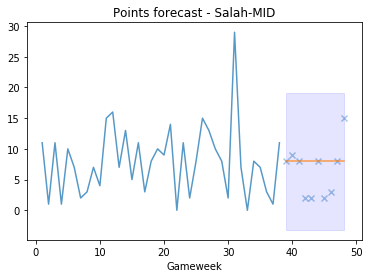

Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=226.517, BIC=229.792, Fit time=0.004 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=228.514, BIC=233.427, Fit time=0.014 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=228.514, BIC=233.427, Fit time=0.014 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=230.107, BIC=236.657, Fit time=0.069 seconds
Total fit time: 0.104 seconds
Test RMSE: Sterling-MID 4.269


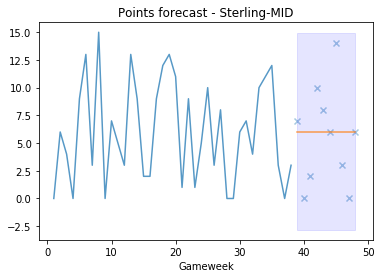

Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=239.176, BIC=249.001, Fit time=0.080 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=236.851, BIC=240.127, Fit time=0.004 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=238.814, BIC=243.726, Fit time=0.015 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=238.785, BIC=243.698, Fit time=0.012 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=236.678, BIC=243.228, Fit time=0.043 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=237.287, BIC=245.475, Fit time=0.085 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=237.185, BIC=245.373, Fit time=0.074 seconds
Total fit time: 0.314 seconds
Test RMSE: Kane-FWD 4.322


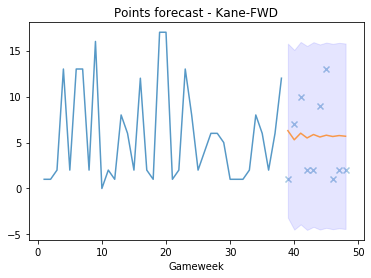

Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=215.563, BIC=225.389, Fit time=0.100 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=214.845, BIC=218.120, Fit time=0.005 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=215.290, BIC=220.203, Fit time=0.017 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=215.336, BIC=220.249, Fit time=0.014 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=217.256, BIC=223.806, Fit time=0.034 seconds
Total fit time: 0.172 seconds
Test RMSE: De Bruyne-MID 5.315


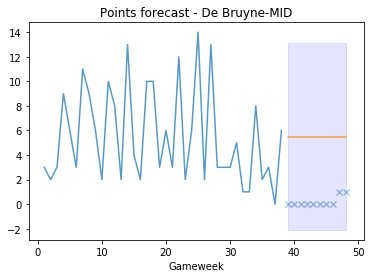

Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=209.766, BIC=219.591, Fit time=0.105 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=205.667, BIC=208.942, Fit time=0.004 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=207.604, BIC=212.517, Fit time=0.011 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=207.621, BIC=212.533, Fit time=0.011 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=209.241, BIC=215.792, Fit time=0.037 seconds
Total fit time: 0.170 seconds
Test RMSE: Eriksen-MID 3.651


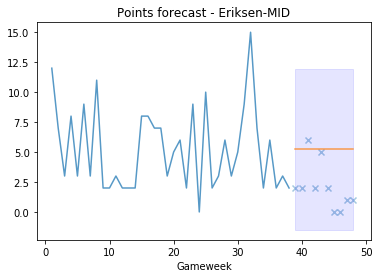

Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=213.134, BIC=216.410, Fit time=0.005 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=213.697, BIC=218.610, Fit time=0.017 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=213.698, BIC=218.610, Fit time=0.023 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=215.657, BIC=222.207, Fit time=0.025 seconds
Total fit time: 0.073 seconds
Test RMSE: Mahrez-MID 4.664


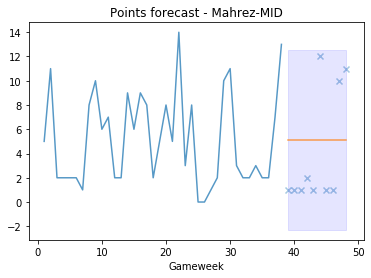

Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=198.668, BIC=208.494, Fit time=0.109 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=203.115, BIC=206.390, Fit time=0.004 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=205.112, BIC=210.025, Fit time=0.013 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=205.106, BIC=210.019, Fit time=0.012 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=203.360, BIC=211.548, Fit time=0.042 seconds
Fit ARIMA: order=(3, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=200.677, BIC=212.140, Fit time=0.139 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 3) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=206.061, BIC=212.611, Fit time=0.033 seconds
Fit ARIMA: order=(3, 0, 3) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, F

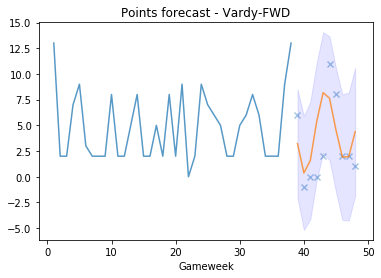

Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=226.528, BIC=236.354, Fit time=0.116 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=220.595, BIC=223.871, Fit time=0.004 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=222.462, BIC=227.374, Fit time=0.013 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=222.478, BIC=227.391, Fit time=0.013 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=224.397, BIC=230.947, Fit time=0.034 seconds
Total fit time: 0.182 seconds
Test RMSE: Firmino-FWD 2.746


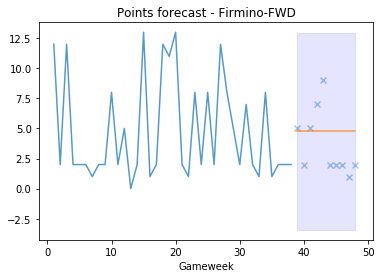

Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=232.735, BIC=242.561, Fit time=0.058 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=227.807, BIC=231.082, Fit time=0.004 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=229.539, BIC=234.452, Fit time=0.013 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=229.616, BIC=234.529, Fit time=0.012 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=229.284, BIC=235.834, Fit time=0.037 seconds
Total fit time: 0.126 seconds
Test RMSE: Sané-MID 3.364


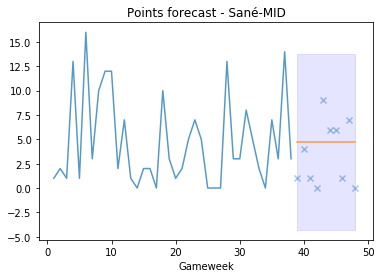

Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=230.108, BIC=239.933, Fit time=0.132 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=228.014, BIC=231.289, Fit time=0.004 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=228.179, BIC=233.092, Fit time=0.014 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=227.663, BIC=232.576, Fit time=0.014 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=229.548, BIC=236.098, Fit time=0.027 seconds
Fit ARIMA: order=(0, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=229.486, BIC=236.037, Fit time=0.018 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=231.360, BIC=239.548, Fit time=0.056 seconds
Total fit time: 0.267 seconds
Test RMSE: Son-MID 3.671


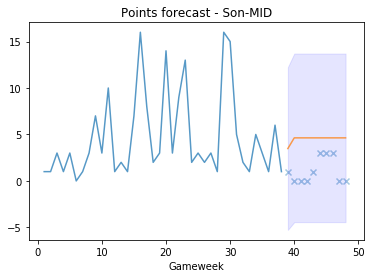

In [185]:
for p in top_10.index:
        models[p] = fit_autoarima(combined_df, p)